In [110]:
import numpy as np
import geopandas as gpd
import shapely
import ipyleaflet
import requests
import threadpool
import json
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from IPython.core.interactiveshell import InteractiveShell

matplotlib.style.use('ggplot')

%matplotlib inline
InteractiveShell.ast_node_interactivity = 'all'
API_ENDPOINT = 'https://envirocar.org/api/stable'

# Data Request

## Track List

In [12]:
# create thread pool to get track list
# for testing, set amount of pages to three
num_track_page = 3
tp_track_list = threadpool.ThreadPool(num_track_page)
track_list = []
def request_track_list(num_page):
    url_track_list = API_ENDPOINT + '/tracks'
    params = {'limit': 100, 'page': num_page}
    response = requests.request('GET', url_track_list, params=params)
    for i in json.loads(response.text)['tracks']:
        track_list.append(i['id'])
tasks = threadpool.makeRequests(request_track_list, [i + 1 for i in range(num_track_page)])
_ = [tp_track_list.putRequest(task) for task in tasks]
tp_track_list.wait()
len(track_list)

300

## Track Points

In [13]:
# get complete tracks
tp_track = threadpool.ThreadPool(50)
list_df_track = []
def request_track(track_id):
    df_tmp = pd.read_csv(API_ENDPOINT + '/tracks/%s.csv' % track_id, sep=';\s+', engine='python')
    df_tmp['track_id'] = df_tmp.apply(lambda x: track_id, axis=1)
    list_df_track.append(df_tmp)
tasks = threadpool.makeRequests(request_track, track_list)
_ = [tp_track.putRequest(task) for task in tasks]
tp_track.wait()
df_track = pd.concat(list_df_track, sort=False)
# df_track.set_index('time', inplace=True)
df_track.head()
df_track.columns

,id,O2 Lambda Voltage(V),CO2(kg/h),GPS Bearing(deg),GPS Altitude(m),GPS HDOP(precision),MAF(l/s),Consumption(l/h),Speed(km/h),GPS Speed(km/h),...,GPS Accuracy(%),GPS PDOP(precision),Intake Temperature(c),Engine Load(%),longitude,latitude,time,track_id,Intake Pressure(kPa),Calculated MAF(g/s)
0,5c1ab21e44ea850302b7708a,2.308046,15.320518,163.741459,1101.864550,0.900000,19.832464,6.519369,76.000001,78.062137,...,8.0,1.793679,12.0,49.150076,-118.057962,36.594371,2018-10-20T16:00:56Z,5c1ab21e44ea850302b77088,NaN,NaN
1,5c1ab21e44ea850302b7708c,2.263177,9.999740,174.784894,1101.277487,0.824138,12.944698,4.255208,78.000000,79.056051,...,8.0,1.724138,12.0,56.296202,-118.057739,36.593394,2018-10-20T16:01:01Z,5c1ab21e44ea850302b77088,NaN,NaN
2,5c1ab21e44ea850302b7708d,2.209688,10.066795,179.873417,1100.807331,0.800000,13.031502,4.283742,80.000002,81.132908,...,8.0,1.800000,12.0,45.883619,-118.057727,36.592374,2018-10-20T16:01:06Z,5c1ab21e44ea850302b77088,NaN,NaN
3,5c1ab21e44ea850302b7708e,2.248132,12.813994,181.148105,1100.208289,1.200000,16.587761,5.452763,81.999999,83.372297,...,8.0,2.100000,12.0,62.037465,-118.057745,36.591357,2018-10-20T16:01:11Z,5c1ab21e44ea850302b77088,NaN,NaN
4,5c1ab21e44ea850302b7708f,2.256135,17.947679,180.145745,1099.768263,0.800000,23.233334,7.637310,83.999999,85.753089,...,8.0,1.800000,12.0,71.605321,-118.057758,36.590306,2018-10-20T16:01:16Z,5c1ab21e44ea850302b77088,NaN,NaN


Index(['id', 'O2 Lambda Voltage(V)', 'CO2(kg/h)', 'GPS Bearing(deg)',
       'GPS Altitude(m)', 'GPS HDOP(precision)', 'MAF(l/s)',
       'Consumption(l/h)', 'Speed(km/h)', 'GPS Speed(km/h)', 'Rpm(u/min)',
       'Throttle Position(%)', 'GPS VDOP(precision)',
       'O2 Lambda Voltage ER(ratio)', 'GPS Accuracy(%)', 'GPS PDOP(precision)',
       'Intake Temperature(c)', 'Engine Load(%)', 'longitude', 'latitude',
       'time', 'track_id', 'Intake Pressure(kPa)', 'Calculated MAF(g/s)'],
      dtype='object')

## Sensors

In [14]:
# get sensor info
num_sensor_page = 5
tp_sensor_list = threadpool.ThreadPool(num_sensor_page)
sensor = {
    'engine_displacement': [],
    'model': [],
    'sensor_id': [],
    'fuel_type': [],
    'construction_year': [],
    'manufacturer': []
}
def request_sensor_list(num_page):
    url_sensor_list = API_ENDPOINT + '/sensors'
    params = {'limit': 100, 'page': num_page}
    response = requests.request('GET', url_sensor_list, params=params)
    for i in json.loads(response.text)['sensors']:
        if not i['type'] == 'car':
            continue
        if 'engineDisplacement' in i['properties'].keys():
            sensor['engine_displacement'].append(i['properties']['engineDisplacement'])
        else:
            sensor['engine_displacement'].append(0)
        sensor['model'].append(i['properties']['model'])
        sensor['fuel_type'].append(i['properties']['fuelType'])
        sensor['sensor_id'].append(i['properties']['id'])
        sensor['construction_year'].append(i['properties']['constructionYear'])
        sensor['manufacturer'].append(i['properties']['manufacturer'])
tasks = threadpool.makeRequests(request_sensor_list, [i + 1 for i in range(num_sensor_page)])
_ = [tp_sensor_list.putRequest(task) for task in tasks]
tp_sensor_list.wait()
df_sensor = pd.DataFrame.from_dict(sensor)
df_sensor.set_index('sensor_id', inplace=True)
df_sensor.head()

,engine_displacement,model,fuel_type,construction_year,manufacturer
sensor_id,,,,,
51c96afce4b0fd063432096f,0,R 1200 GS ADV,gasoline,2012,BMW
51c96d7ae4b0fd0634320bbd,0,Picanto,gasoline,2005,KIA
51c97f0ee4b05956bbffcef8,0,Z4,gasoline,2001,BMW
51c9a6dfe4b0fe5a04ea676e,0,Golf,gasoline,2005,Volkswagen
51c9b583e4b0fe5a04eab3d0,0,Leon,gasoline,2011,Seat


# Visualization

## Draw single trajectory on map

In [52]:
def get_trajectory(track_id):
    # get dataframe for points of a single track
    df_single_track = df_track[df_track['track_id'] == track_id].copy()
    df_single_track['geometry'] = df_single_track.apply(lambda x: shapely.geometry.Point(x['longitude'], x['latitude']), axis=1)
    df_single_track = gpd.GeoDataFrame(df_single_track)
    # generate line from point, props come from the first point
    ds_next_point = df_single_track['geometry'].copy()
    ds_next_point = ds_next_point.drop(0)
    ds_next_point = ds_next_point.reset_index()
    df_single_track_line = df_single_track.drop(df_single_track.index[len(df_single_track) - 1])
    df_single_track_line['next_point'] = ds_next_point['geometry']
    df_single_track_line['line'] = df_single_track_line.apply(lambda x: shapely.geometry.LineString([x['geometry'], x['next_point']]), axis=1)
    df_single_track_line = df_single_track_line.set_geometry('line')
    return df_single_track_line
    
df_single_track_line=get_trajectory(track_list[0])
df_single_track_line.head()

,id,O2 Lambda Voltage(V),CO2(kg/h),GPS Bearing(deg),GPS Altitude(m),GPS HDOP(precision),MAF(l/s),Consumption(l/h),Speed(km/h),GPS Speed(km/h),...,Engine Load(%),longitude,latitude,time,track_id,Intake Pressure(kPa),Calculated MAF(g/s),geometry,next_point,line
0,5c1ab30344ea850302b7c3b1,2.246638,23.850216,180.310558,634.922652,1.000000,30.874189,10.149028,79.999998,82.257811,...,75.506725,-116.036744,34.112546,2018-10-24T20:13:23Z,5c1ab30344ea850302b7c3af,NaN,NaN,POINT (-116.0367437794158 34.1125461045748),POINT (-116.0367488174539 34.11150738619558),LINESTRING (-116.0367437794158 34.112546104574...
1,5c1ab30344ea850302b7c3b3,2.242285,23.650241,180.644510,641.423711,1.194561,30.615321,10.063932,81.999999,82.504665,...,78.170489,-116.036749,34.111507,2018-10-24T20:13:28Z,5c1ab30344ea850302b7c3af,NaN,NaN,POINT (-116.0367488174539 34.11150738619558),POINT (-116.036761438649 34.11047255764483),LINESTRING (-116.0367488174539 34.111507386195...
2,5c1ab30344ea850302b7c3b4,2.245908,23.670384,180.049716,646.423545,1.096677,30.641396,10.072504,82.000002,82.855271,...,80.353542,-116.036761,34.110473,2018-10-24T20:13:33Z,5c1ab30344ea850302b7c3af,NaN,NaN,POINT (-116.036761438649 34.11047255764483),POINT (-116.0367705557485 34.10944613943527),LINESTRING (-116.036761438649 34.1104725576448...
3,5c1ab30344ea850302b7c3b5,2.231079,27.620267,180.427249,651.478627,1.000000,35.754533,11.753305,80.000000,81.541296,...,82.610548,-116.036771,34.109446,2018-10-24T20:13:38Z,5c1ab30344ea850302b7c3af,NaN,NaN,POINT (-116.0367705557485 34.10944613943527),POINT (-116.0367774662187 34.1084099754667),LINESTRING (-116.0367705557485 34.109446139435...
4,5c1ab30344ea850302b7c3b6,2.203860,20.757025,180.409703,656.681100,1.098761,26.870043,8.832777,82.000002,84.165084,...,58.630552,-116.036777,34.108410,2018-10-24T20:13:43Z,5c1ab30344ea850302b7c3af,NaN,NaN,POINT (-116.0367774662187 34.1084099754667),POINT (-116.0367782980945 34.10736299360313),LINESTRING (-116.0367774662187 34.108409975466...


In [81]:
# create map use ipyleaflet
bounds = df_single_track_line.total_bounds
m = ipyleaflet.Map(center=((bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2),zoom=12)
map_layer = ipyleaflet.basemap_to_tiles(ipyleaflet.basemaps.OpenStreetMap.BlackAndWhite)
# convert datatframe to json
tmp = gpd.GeoDataFrame(df_single_track_line[['line', 'Speed(km/h)']])
tmp = tmp.set_geometry('line')
json_single_track = json.loads(tmp.to_json())
track_layer = ipyleaflet.GeoJSON(data=json_single_track, style={'color': 'blue', 
                                                                'opacity': 1, 'weight':1.9})
# m.add_layer(map_layer)
m.add_layer(track_layer)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

## Draw single trajectory in graph

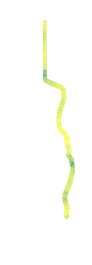

In [94]:
# simplely draw a line in pyplot
# the color of each part of the track decided by speed
_ = df_single_track_line.plot(column='Speed(km/h)', cmap='summer', linewidth=5)
_ = plt.axis('off')

## Draw multi trajectories

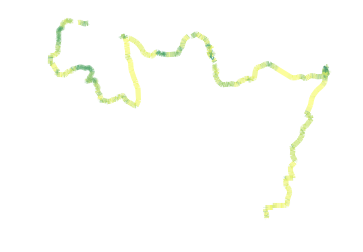

In [109]:
# draw multi tracks on graph, set number to 30 due to time
# There is a problem: Although the trick ids are different, these tracks seem to belong to one trip as shown in 
# plot. I didn't get the access of 'user'(it's listed in the documents) successfully, so I can't
# figure out if these tracks are from the same user(trip).
num_track = 30
list_df_track = [get_trajectory(track_list[i]) for i in range(num_track)]
_, ax = plt.subplots()
ax.set_aspect('equal')
_ = [track.plot(ax=ax, column='Speed(km/h)', cmap='summer', linewidth=5) for track in list_df_track]
_ = plt.axis('off')

# Analysis Based on Tracks

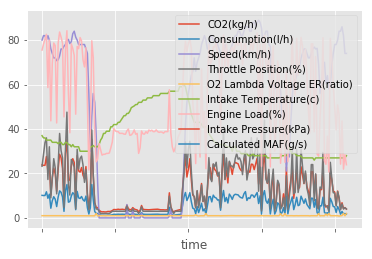

In [104]:
# Due to the deadline and some other reason of my own, I'm sorry to say that I don't have 
# enough time to finish any meaningful analyses, and I just do some easy work.
# In general, I think the analyses can be divided into two categories. One is analysis for 
# trajectory itself, another is analysis for the city through various trajectories.
# I just make an example for the former due to the same reason mentioned above.

# I draw a curve for each sensor measurements to show their change with time and the 
# speed can be a benchmark.
# According to the figure most sensor show a obvious relationship with the speed of the car
df_c = df_single_track_line[['CO2(kg/h)',
                      'Consumption(l/h)', 
                      'Speed(km/h)', 
                      # 'Rpm(u/min)',
                      'Throttle Position(%)', 
                      'O2 Lambda Voltage ER(ratio)', 
                      'Intake Temperature(c)', 
                      'Engine Load(%)', 
                      'Intake Pressure(kPa)', 
                      'Calculated MAF(g/s)']]
_ = df_c.plot()

In [107]:
# then calcaulate the correlation coefficient matrix
# as a result, the consumption and CO2 show the most obvious positive correlation with speed
# while the Intake Temperature has a negetive correlation
coor = df_c.corr()
coor
coor['Speed(km/h)'].sort_values(ascending=False)

,CO2(kg/h),Consumption(l/h),Speed(km/h),Throttle Position(%),O2 Lambda Voltage ER(ratio),Intake Temperature(c),Engine Load(%),Intake Pressure(kPa),Calculated MAF(g/s)
CO2(kg/h),1.000000,1.000000,0.685200,0.970603,-0.207949,-0.435100,0.938199,NaN,NaN
Consumption(l/h),1.000000,1.000000,0.685200,0.970603,-0.207949,-0.435100,0.938199,NaN,NaN
Speed(km/h),0.685200,0.685200,1.000000,0.640000,0.046979,-0.753923,0.592491,NaN,NaN
Throttle Position(%),0.970603,0.970603,0.640000,1.000000,-0.182423,-0.398707,0.928227,NaN,NaN
O2 Lambda Voltage ER(ratio),-0.207949,-0.207949,0.046979,-0.182423,1.000000,-0.116955,-0.311646,NaN,NaN
Intake Temperature(c),-0.435100,-0.435100,-0.753923,-0.398707,-0.116955,1.000000,-0.343724,NaN,NaN
Engine Load(%),0.938199,0.938199,0.592491,0.928227,-0.311646,-0.343724,1.000000,NaN,NaN
Intake Pressure(kPa),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Calculated MAF(g/s),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Speed(km/h)                    1.000000
Consumption(l/h)               0.685200
CO2(kg/h)                      0.685200
Throttle Position(%)           0.640000
Engine Load(%)                 0.592491
O2 Lambda Voltage ER(ratio)    0.046979
Intake Temperature(c)         -0.753923
Intake Pressure(kPa)                NaN
Calculated MAF(g/s)                 NaN
Name: Speed(km/h), dtype: float64

# Ideas of enviroCar Data for GsoC
## Monitor the status of the vehicle
The vehicle's current operating status is monitored from the vehicle's various sensor indicators, and the vehicle status can be further evaluated and early warnings of possible long-term faults can be made (generally, the vehicle itself has a temporary fault reporting function, So we can focus on long-term failures prediction).
## Comparation among various models of cars
By comparing the long-term trajectories of vehicles of different models, the performance differences between these models are analyzed and compared. This may provide a more realistic and intuitive angle for vehicle purchasers.
## Analysis of the traffic information
By matching a large number of intra-city trajectories with roads and taking urban roads as research targets, information on urban roads, such as congestion, can be further analyzed.
## Analysis of the urban region using the graph-based method
Graph-based trajectory analysis is a popular research method in recent years. It transforms trajectory data into directed graphs by using urban partitions (grids, traffic sub-areas, etc.), and uses graph analysis methods to analyze urban structural features. This is also a study I am currently working on, so I also want to add this analysis method to the analysis module.

# Structure of Python Package

As mentioned before, I prefer to work to create a complete and extensive scalable trajectory analysis module that will first be developed based on enviroCar data, but I will also pave the way for future expansions, such as more ubiquitous data structures ,reserved data interfaces, etc. 

The file structure of the module I envisioned is as follows：
```
ProjectName
│   README.md
│   License file   
│   CI file(travisCI)   
│   Version file(git)  
│   setup.py  
│
└───ModuleName
│   │   __init__.py
│   │   test.py
│   │
│   └───model
│   │   │   __init__.py
│   │   │   TrajectoryModel.py(can get tracks as specific point, line or od data)
│   │   │   TrajectoryNetworkModel.py(network for the grids of city connected by tracks)
│   │   │   ...
│   └───io
│   │   │   __init__.py
│   │   │   enviroCar.py(interface for enviroCar API)
│   │   │   ...(maybe file, database, etc.)
│   └───vis
│   │   │   __init__.py
│   │   │   View.py
│   │   │   MapView.py
│   │   │   PlotView.py
│   │   │   ...(plan to develop the vis module using javascript and I'm now working on it.)
│   └───algorithm
│   │   │   __init__.py
│   │   │   MapMatch.py(using some opensource service)
│   │   │   Smooth.py
│   │   │   Denoising.py
│   │   │   Dilution.py
│   │   │   Clustering.py
│   │   │   ...
│   └───test
│        │   __init__.py
│        │   ...
│
└───static
│   │   data
│   │   img
│   │   js
│   │   style
└───docs

```